✅ Using device: MPS (Mac M4 GPU)

Preparing Imbalanced CIFAR10...


100.0%
/Users/divyarao/Documents/sem6/dl/dl lab/.venv/lib/python3.14/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Class distribution after imbalance: {0: 5000, 1: 2997, 2: 1796, 3: 1077, 4: 645, 5: 387, 6: 232, 7: 139, 8: 83, 9: 50}

=== EXP 1: Baseline (Imbalanced Data) ===

>>> Training BaselineCNN...
Epoch [1/10] Loss: 1.1267 | Acc: 62.22%
Epoch [2/10] Loss: 0.8780 | Acc: 70.53%
Epoch [3/10] Loss: 0.8006 | Acc: 73.37%
Epoch [4/10] Loss: 0.7559 | Acc: 74.90%
Epoch [5/10] Loss: 0.6999 | Acc: 76.58%
Epoch [6/10] Loss: 0.6695 | Acc: 77.74%
Epoch [7/10] Loss: 0.6386 | Acc: 78.90%
Epoch [8/10] Loss: 0.6022 | Acc: 80.04%
Epoch [9/10] Loss: 0.5950 | Acc: 80.03%
Epoch [10/10] Loss: 0.5664 | Acc: 80.89%
Final Test F1-Score (Macro): 0.3615


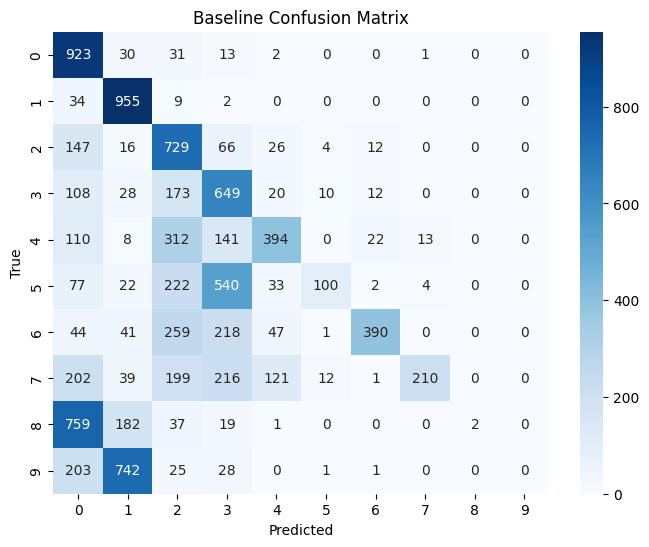


=== EXP 2: Class Weighting ===

>>> Training WeightedCNN...
Epoch [1/10] Loss: 2.0599 | Acc: 33.06%
Epoch [2/10] Loss: 1.7668 | Acc: 40.65%
Epoch [3/10] Loss: 1.6514 | Acc: 42.67%
Epoch [4/10] Loss: 1.5898 | Acc: 42.80%
Epoch [5/10] Loss: 1.5270 | Acc: 42.40%
Epoch [6/10] Loss: 1.4686 | Acc: 43.97%
Epoch [7/10] Loss: 1.3971 | Acc: 47.43%
Epoch [8/10] Loss: 1.3389 | Acc: 50.47%
Epoch [9/10] Loss: 1.3058 | Acc: 49.80%
Epoch [10/10] Loss: 1.2971 | Acc: 50.41%
Final Test F1-Score (Macro): 0.4617

=== EXP 3: Random Oversampling ===

>>> Training OversampledCNN...
Epoch [1/10] Loss: 1.5872 | Acc: 41.95%
Epoch [2/10] Loss: 1.1326 | Acc: 58.73%
Epoch [3/10] Loss: 0.9320 | Acc: 66.15%
Epoch [4/10] Loss: 0.8016 | Acc: 70.20%
Epoch [5/10] Loss: 0.7200 | Acc: 74.13%
Epoch [6/10] Loss: 0.6640 | Acc: 76.11%
Epoch [7/10] Loss: 0.6015 | Acc: 78.54%
Epoch [8/10] Loss: 0.5369 | Acc: 80.62%
Epoch [9/10] Loss: 0.5062 | Acc: 81.81%
Epoch [10/10] Loss: 0.4823 | Acc: 82.48%
Final Test F1-Score (Macro): 0.59

100.0%



>>> Training ResNet18_TL...
Epoch [1/10] Loss: 1.9133 | Acc: 39.22%
Epoch [2/10] Loss: 1.7526 | Acc: 42.84%
Epoch [3/10] Loss: 1.4587 | Acc: 49.56%
Epoch [4/10] Loss: 1.2071 | Acc: 54.31%
Epoch [5/10] Loss: 1.0558 | Acc: 62.56%
Epoch [6/10] Loss: 0.9697 | Acc: 64.54%
Epoch [7/10] Loss: 0.8843 | Acc: 68.39%
Epoch [8/10] Loss: 0.6689 | Acc: 75.08%
Epoch [9/10] Loss: 0.6368 | Acc: 76.83%
Epoch [10/10] Loss: 0.5377 | Acc: 80.03%
Final Test F1-Score (Macro): 0.6547

=== Final Visualization ===
Comparing Baseline vs Focal Loss Feature Space
Generating t-SNE plot...


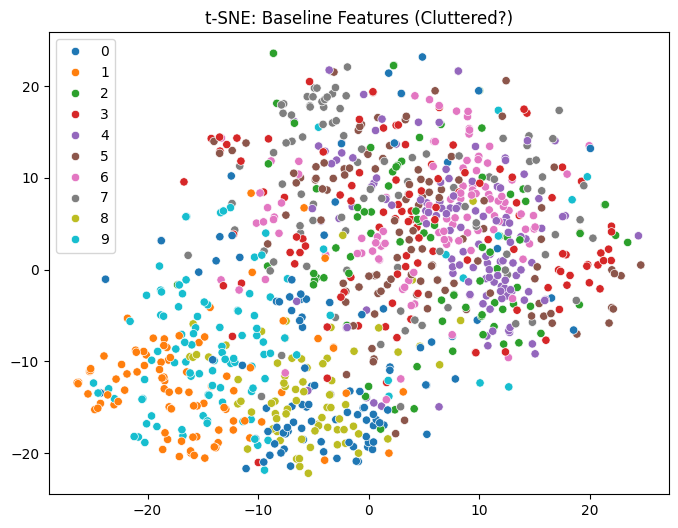

Generating t-SNE plot...


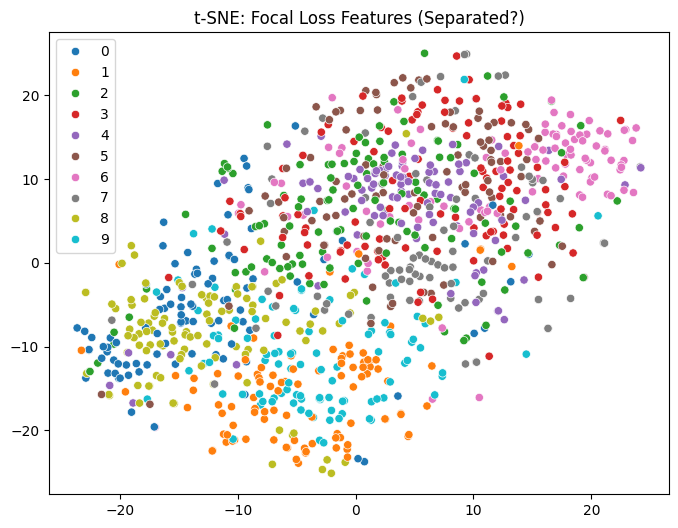

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import copy

# --- 1. CONFIGURATION & DEVICE SETUP (Mac M4 Optimization) ---
# Check for MPS (Apple Silicon) support
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("✅ Using device: MPS (Mac M4 GPU)")
else:
    DEVICE = torch.device("cpu")
    print("⚠️ MPS not found. Using CPU.")

BATCH_SIZE = 64
EPOCHS = 10  # Increase to 20+ for better convergence
LEARNING_RATE = 0.001
IMBALANCE_RATIO = 0.01  # Ratio of minority class size to majority class size

# --- 2. DATASET PREPARATION (Creating Imbalance) ---

def get_imbalanced_dataset(dataset_name='CIFAR10', root='./data'):
    """
    Downloads dataset and creates a long-tailed imbalance.
    Class 0 gets 100% data, Class 1 gets 90%... Class 9 gets ~1% data.
    """
    print(f"\nPreparing Imbalanced {dataset_name}...")
    
    # Transforms (ResNet expects 224x224, but we stick to 32x32 for speed unless specified)
    transform_train = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    transform_test = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    if dataset_name == 'CIFAR10':
        trainset = torchvision.datasets.CIFAR10(root=root, train=True, download=True, transform=transform_train)
        testset = torchvision.datasets.CIFAR10(root=root, train=False, download=True, transform=transform_test)
        num_classes = 10
    elif dataset_name == 'FashionMNIST':
        trainset = torchvision.datasets.FashionMNIST(root=root, train=True, download=True, transform=transform_train)
        testset = torchvision.datasets.FashionMNIST(root=root, train=False, download=True, transform=transform_test)
        # Repeat channel to 3 for FashionMNIST to match models
        trainset.data = trainset.data.unsqueeze(1).repeat(1, 3, 1, 1) if dataset_name=='FashionMNIST' else trainset.data
        num_classes = 10
    
    # --- Create Long-Tailed Imbalance ---
    targets = np.array(trainset.targets)
    indices = []
    class_counts = {}
    
    # Exponential decay for sample counts
    max_samples = 5000
    for c in range(num_classes):
        # Sample count drops as class index increases
        num_samples = int(max_samples * (IMBALANCE_RATIO ** (c / (num_classes - 1.0))))
        class_indices = np.where(targets == c)[0]
        selected_indices = np.random.choice(class_indices, num_samples, replace=False)
        indices.extend(selected_indices)
        class_counts[c] = num_samples
        
    print(f"Class distribution after imbalance: {class_counts}")
    
    imbalanced_trainset = Subset(trainset, indices)
    
    # Calculate Class Weights for Loss Function
    total_samples = sum(class_counts.values())
    class_weights = [total_samples / (num_classes * count) for count in class_counts.values()]
    class_weights = torch.FloatTensor(class_weights).to(DEVICE)
    
    # Calculate Sampler Weights for Oversampling
    sample_weights = []
    for idx in indices:
        label = targets[idx]
        sample_weights.append(1.0 / class_counts[label])
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(indices), replacement=True)
    
    return imbalanced_trainset, testset, class_weights, sampler, num_classes

# --- 3. MODEL ARCHITECTURES ---

# Problem Statement 1: Custom CNN
class CustomCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 16x16
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 8x8
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 4x4
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        features = torch.flatten(x, 1) # Extract features for t-SNE
        out = self.classifier(x)
        return out, features

# Problem Statement 6: Transfer Learning (ResNet18)
def get_resnet_model(num_classes=10):
    print("Loading Pre-trained ResNet18...")
    model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
    # Modify input layer for 32x32 images (CIFAR-10) to avoid shrinking too much
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity() 
    model.fc = nn.Linear(512, num_classes)
    return model

# --- 4. LOSS FUNCTIONS ---

# Problem Statement 4: Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        return focal_loss.sum()

# --- 5. TRAINING ENGINE ---

def train_model(model, train_loader, test_loader, criterion, optimizer, name="Model"):
    print(f"\n>>> Training {name}...")
    model = model.to(DEVICE)
    train_losses, train_accs = [], []
    
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            
            # Forward
            if isinstance(model, CustomCNN):
                outputs, _ = model(inputs)
            else:
                outputs = model(inputs)
                
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        epoch_acc = 100 * correct / total
        train_losses.append(running_loss / len(train_loader))
        train_accs.append(epoch_acc)
        print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {running_loss/len(train_loader):.4f} | Acc: {epoch_acc:.2f}%")

    # Final Evaluation
    model.eval()
    all_preds = []
    all_labels = []
    all_features = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            if isinstance(model, CustomCNN):
                outputs, feats = model(inputs)
                all_features.append(feats.cpu())
            else:
                outputs = model(inputs)
                
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Metrics
    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"Final Test F1-Score (Macro): {f1:.4f}")
    
    return all_labels, all_preds, (torch.cat(all_features) if all_features else None)

# --- 6. VISUALIZATION ---

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

def plot_tsne(features, labels, title="t-SNE Visualization"):
    print("Generating t-SNE plot...")
    if features is None: return
    
    # Subset for speed
    n_samples = 1000
    indices = np.random.choice(features.shape[0], min(n_samples, features.shape[0]), replace=False)
    features_subset = features[indices]
    labels_subset = np.array(labels)[indices]
    
    tsne = TSNE(n_components=2, random_state=42)
    tsne_res = tsne.fit_transform(features_subset)
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=tsne_res[:,0], y=tsne_res[:,1], hue=labels_subset, palette='tab10', legend='full')
    plt.title(title)
    plt.show()

# --- 7. MAIN EXECUTION ---

if __name__ == "__main__":
    # A. PREPARE DATA
    train_set, test_set, class_weights, sampler, num_classes = get_imbalanced_dataset('CIFAR10')
    
    # Dataloaders
    # 1. Standard Loader (Imbalanced)
    train_loader_std = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    # 2. Oversampled Loader (Balanced Batching)
    train_loader_oversampled = DataLoader(train_set, batch_size=BATCH_SIZE, sampler=sampler)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

    # --- EXPERIMENT 1: Baseline (CustomCNN + CE Loss) ---
    print("\n=== EXP 1: Baseline (Imbalanced Data) ===")
    model_base = CustomCNN(num_classes)
    optimizer = optim.Adam(model_base.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    y_true, y_pred_base, features_base = train_model(model_base, train_loader_std, test_loader, criterion, optimizer, "BaselineCNN")
    plot_confusion_matrix(y_true, y_pred_base, "Baseline Confusion Matrix")

    # --- EXPERIMENT 2: Class Weighting (CustomCNN + Weighted CE) ---
    print("\n=== EXP 2: Class Weighting ===")
    model_weight = CustomCNN(num_classes)
    optimizer = optim.Adam(model_weight.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(weight=class_weights) # KEY CHANGE
    y_true, y_pred_weight, _ = train_model(model_weight, train_loader_std, test_loader, criterion, optimizer, "WeightedCNN")
    
    # --- EXPERIMENT 3: Oversampling (CustomCNN + WeightedRandomSampler) ---
    print("\n=== EXP 3: Random Oversampling ===")
    model_over = CustomCNN(num_classes)
    optimizer = optim.Adam(model_over.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    # Using oversampled loader here
    y_true, y_pred_over, _ = train_model(model_over, train_loader_oversampled, test_loader, criterion, optimizer, "OversampledCNN")

    # --- EXPERIMENT 4: Focal Loss (CustomCNN + Focal Loss) ---
    print("\n=== EXP 4: Focal Loss ===")
    model_focal = CustomCNN(num_classes)
    optimizer = optim.Adam(model_focal.parameters(), lr=LEARNING_RATE)
    criterion = FocalLoss(gamma=2) # KEY CHANGE
    y_true, y_pred_focal, features_focal = train_model(model_focal, train_loader_std, test_loader, criterion, optimizer, "FocalLossCNN")
    
    # --- EXPERIMENT 5: Transfer Learning (ResNet18) ---
    print("\n=== EXP 5: Transfer Learning (ResNet18) ===")
    model_tl = get_resnet_model(num_classes)
    optimizer = optim.Adam(model_tl.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(weight=class_weights) # Combine TL with weighting
    y_true, y_pred_tl, _ = train_model(model_tl, train_loader_std, test_loader, criterion, optimizer, "ResNet18_TL")

    # --- VISUALIZATION OF BEST MODEL ---
    print("\n=== Final Visualization ===")
    print("Comparing Baseline vs Focal Loss Feature Space")
    plot_tsne(features_base, y_true, "t-SNE: Baseline Features (Cluttered?)")
    plot_tsne(features_focal, y_true, "t-SNE: Focal Loss Features (Separated?)")